In [ ]:
!pip install -Uqq fastbook
!pip install mplsoccer --quiet

In [ ]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import gc

orig_url='https://drive.google.com/file/d/1OWRqfE-YXWja5XWRjl6pgV-hDdW0dG-k/view'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

In [ ]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,TrÃ©zÃ©guet,Cross
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross


### Data Preprocessing and Splitting

In [ ]:
pdf = df.query("(result != ['OwnGoal', 'BlockedShot']) & (situation != 'DirectFreekick')").reset_index(drop=True)
pdf['result'] = pdf["result"].map({"MissedShots": "Miss", "SavedShot":"Miss", "Goal":"Goal", "ShotOnPost": "Miss"})

In [ ]:
cat_features = ["situation", "shotType", "lastAction"]
cont_features = ["minute", "X", "Y"]
features = cat_features + cont_features
target = "result"
pdf = pdf[features+[target]]

In [ ]:
pdf.head()

,situation,shotType,lastAction,minute,X,Y,result
0,OpenPlay,Head,Cross,54,0.878,0.430,Miss
1,OpenPlay,RightFoot,Pass,77,0.858,0.679,Miss
2,OpenPlay,RightFoot,TakeOn,34,0.831,0.655,Miss
3,FromCorner,Head,Cross,46,0.943,0.500,Miss
4,OpenPlay,LeftFoot,Pass,3,0.916,0.524,Goal


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(pdf, shuffle=True, stratify=pdf['result'], test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)

(168071, 7)
(42018, 7)


### Modelling

In [ ]:
from fastai.tabular.all import *

splits = RandomSplitter(valid_pct=0.2)(range_of(pdf))

dls = TabularDataLoaders.from_df(df=X_train, y_names=target, 
                                 cat_names = cat_features,
                                 cont_names = cont_features,
                                 procs = [Categorify, Normalize],
                                 splits = splits)

In [ ]:
metric = RocAucBinary()
learn = tabular_learner(dls, metrics=metric)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.330051,0.331644,0.799301,00:20
1,0.334968,0.325973,0.807553,00:20


In [ ]:
learn.layers

Sequential(
  (0): LinBnDrop(
    (0): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=23, out_features=200, bias=False)
    (2): ReLU(inplace=True)
  )
  (1): LinBnDrop(
    (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=200, out_features=100, bias=False)
    (2): ReLU(inplace=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=100, out_features=2, bias=True)
  )
)

### Inference

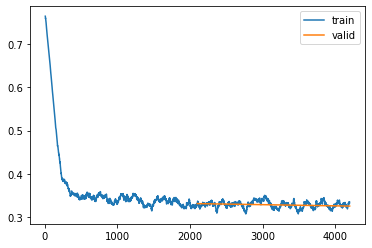

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results()

,situation,shotType,lastAction,minute,X,Y,result,result_pred
0,2.0,4.0,26.0,-1.220385,-0.846470,1.641907,1.0,1.0
1,2.0,1.0,1.0,-1.745827,0.380647,0.467340,1.0,1.0
2,2.0,2.0,24.0,-0.732474,1.430655,-0.159624,0.0,0.0
3,4.0,4.0,28.0,0.355941,1.633066,-0.778653,1.0,1.0
4,2.0,4.0,26.0,-0.469753,-0.466949,-0.191370,1.0,1.0
5,2.0,1.0,28.0,-1.145322,0.722215,-0.223115,1.0,1.0
6,1.0,4.0,19.0,1.256699,1.367402,-0.858016,0.0,1.0
7,2.0,2.0,26.0,-1.708295,0.001127,-1.334192,1.0,1.0
8,2.0,2.0,26.0,1.031510,0.013777,0.443532,1.0,1.0


In [ ]:
test_df = X_valid.copy()
test_df.drop([target], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

test_preds = learn.get_preds(dl=dl)
xg_predictions = test_preds[0][:, 0]

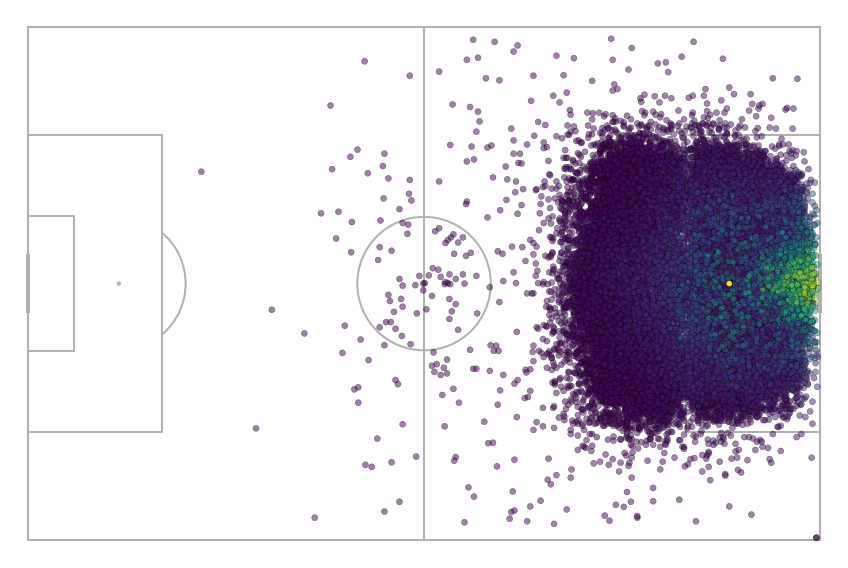

In [ ]:
from mplsoccer import Pitch

pitch = Pitch(pitch_type='opta')  # 
fig, ax = pitch.draw(figsize=(12, 8))
ax.scatter(test_df["X"]*100, test_df["Y"]*100, c=xg_predictions, 
           cmap='viridis', alpha=0.5, ec='k', lw=0.5)